In [1]:
!git clone https://github.com/hungvotranchi/ComputerVision.git

Cloning into 'ComputerVision'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 5), reused 39 (delta 5), pack-reused 0
Unpacking objects: 100% (42/42), 3.67 MiB | 9.62 MiB/s, done.


In [2]:
import os
os.chdir("ComputerVision/ImageClassification")
!sh scripts/download.sh
os.chdir("model")

--2024-03-09 07:31:44--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz'

cifar-10-python.tar 100%[===================>] 162.60M  49.7MB/s    in 3.6s    

2024-03-09 07:31:48 (45.3 MB/s) - 'cifar-10-python.tar.gz' saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn


import sys
sys.path.append("..")
from src.load_data import load_CIFAR10
from src.preprocess import transform_VGGModel
from src.plotting import imshow
from model.VGG import VGG16
from src.train_predict import train, test_classification

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
batch_size = 128

train_set, test_set = load_CIFAR10(transform_VGGModel())
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, \
                                               shuffle = True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, \
                                               shuffle = True, num_workers = 2)

In [6]:
classes = train_set.classes

Training

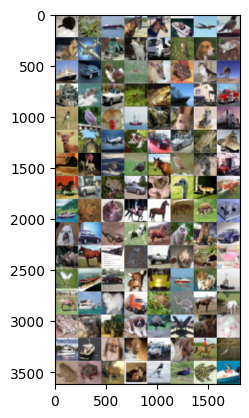

<generator object <genexpr> at 0x7c77c96a7d10>


In [7]:
dataiter = iter(train_dataloader)
img, labels = next(dataiter)

imshow(torchvision.utils.make_grid(img))
print(" ".join(f'{classes[labels[j]]}') for j in range(batch_size))


In [8]:
img.shape

torch.Size([128, 3, 224, 224])

In [9]:
model = VGG16(num_class= len(classes))

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
train(num_loops= 20, criterion= criterion, optim= optimizer, model= model, \
      train_dataloader= train_dataloader, device= device, path = "VGG16_cifar10.pth")

Finished Training


Testing

In [13]:
model_pred = VGG16(num_class= len(classes))
model_pred.load_state_dict(torch.load("VGG16_cifar10.pth"))

<All keys matched successfully>

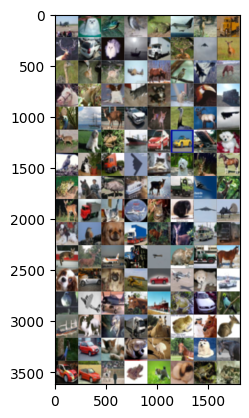

Ground truth:  airplane dog bird bird frog airplane deer truck deer automobile cat ship truck deer airplane deer bird cat deer airplane deer bird airplane horse horse frog dog cat dog dog bird truck bird ship deer automobile dog bird deer airplane deer dog frog ship automobile automobile truck dog bird cat truck airplane cat dog deer horse frog horse bird ship deer truck airplane deer deer truck cat airplane cat bird airplane airplane dog bird dog truck deer deer truck truck cat deer airplane truck airplane cat truck horse dog automobile dog airplane automobile airplane dog ship bird airplane airplane horse ship frog automobile bird ship dog dog truck horse frog horse deer bird automobile cat frog bird horse dog horse automobile automobile horse frog cat dog frog frog
Predict:  truck deer cat truck ship bird automobile ship deer truck ship automobile ship frog ship cat automobile deer deer ship cat cat deer cat ship cat frog truck frog bird deer cat automobile dog deer dog deer frog fr

In [14]:
dataiter = iter(test_dataloader)
img, labels = next(dataiter)
_, predicts = torch.max(model_pred(img), 1)


imshow(torchvision.utils.make_grid(img))
print("Ground truth: ", " ".join(f"{classes[labels[j]]}" for j in range(batch_size)))
print("Predict: ", " ".join(f"{classes[predicts[j]]}" for j in range(batch_size)))


In [15]:
test_classification(model= model_pred, test_dataloader= test_dataloader, \
                    device= device, classes= classes)

Accuracy of the network in the test dataset: 10 %
Accuracy for class airplane: 2.7
Accuracy for class automobile: 12.1
Accuracy for class bird: 3.1
Accuracy for class cat: 16.0
Accuracy for class deer: 15.7
Accuracy for class dog: 5.5
Accuracy for class frog: 13.8
Accuracy for class horse: 0.8
Accuracy for class ship: 13.3
Accuracy for class truck: 17.3


Loading from pretrained

In [25]:
from torchvision.models import vgg16,VGG16_Weights

models_pretrained = vgg16(pretrained = True)

#Freeze the layers
for param in models_pretrained.parameters():
    param.requires_grad = False
    
num_features = models_pretrained.classifier[0].in_features  # Get the number of input features of the first layer
new_classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, len(classes))  
)

# Replace the original classifier with the new classifier
models_pretrained.classifier = new_classifier

# Check the modified model architecture
print(models_pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
models_pretrained.to(device)
train(num_loops= 5, criterion= criterion, optim= optimizer, model= models_pretrained, \
      train_dataloader= train_dataloader, device= device, path = "VGG16Pretrained_cifar10.pth")

Finished Training


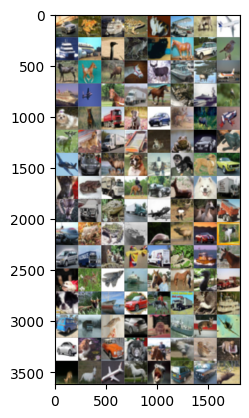

Ground truth:  automobile frog ship frog cat airplane deer airplane ship airplane bird cat cat horse automobile bird horse horse deer horse deer ship deer airplane ship airplane horse truck horse cat airplane bird dog dog truck dog automobile deer deer frog deer dog truck truck frog frog automobile frog airplane automobile deer dog airplane dog dog automobile dog frog truck horse automobile deer dog truck deer truck frog truck airplane deer horse truck airplane frog frog ship bird deer automobile dog automobile truck cat airplane truck bird ship horse dog deer airplane ship horse horse bird truck dog deer ship automobile horse truck bird ship automobile truck bird automobile cat ship cat airplane automobile dog automobile dog horse horse bird dog deer horse airplane horse bird automobile automobile deer
Predict:  bird frog cat dog frog dog dog cat cat ship ship cat frog frog dog dog dog ship dog frog ship cat bird ship ship airplane horse dog ship horse truck truck airplane frog automo

In [29]:
model_pred = models_pretrained
model_pred.load_state_dict(torch.load("VGG16Pretrained_cifar10.pth"))
dataiter = iter(test_dataloader)
img, labels = next(dataiter)
model_pred.to('cpu')
_, predicts = torch.max(model_pred(img), 1)


imshow(torchvision.utils.make_grid(img))
print("Ground truth: ", " ".join(f"{classes[labels[j]]}" for j in range(batch_size)))
print("Predict: ", " ".join(f"{classes[predicts[j]]}" for j in range(batch_size)))


In [30]:
model_pred.to(device)
test_classification(model= model_pred, test_dataloader= test_dataloader, \
                    device= device, classes= classes)

Accuracy of the network in the test dataset: 9 %
Accuracy for class airplane: 8.0
Accuracy for class automobile: 6.2
Accuracy for class bird: 8.1
Accuracy for class cat: 17.7
Accuracy for class deer: 4.0
Accuracy for class dog: 15.9
Accuracy for class frog: 21.3
Accuracy for class horse: 1.1
Accuracy for class ship: 14.8
Accuracy for class truck: 1.7
